In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [9]:
recordings = os.listdir("Recordings/training")

In [63]:
df = pd.DataFrame()
df["filenames"] = recordings
df["labels"] = [recording.split('.')[0] for recording in recordings]
df["mapped_labels"] = df["labels"].map({"Apple":0, "Cherry":1, "Orange":2, "Unknown":3})

In [64]:
print(df)
df.to_csv("labels.csv")

                                             filenames   labels  mapped_labels
0     Apple.5kh0pmfj.ingestion-8474d8fb45-pdwsh.s5.wav    Apple            0.0
1    Cherry.5kh1qkbd.ingestion-8474d8fb45-9wskt.s5.wav   Cherry            1.0
2     Apple.5kh0cn3e.ingestion-8474d8fb45-9wskt.s1.wav    Apple            0.0
3    Cherry.5kh2800p.ingestion-8474d8fb45-6skpk.s8.wav   Cherry            1.0
4    Cherry.5kh21qib.ingestion-8474d8fb45-pdwsh.s4.wav   Cherry            1.0
..                                                 ...      ...            ...
237  Orange.5kh3h8ol.ingestion-8474d8fb45-6skpk.s8.wav   Orange            2.0
238  Orange.5kh48ndd.ingestion-8474d8fb45-pdwsh.s4.wav   Orange            2.0
239  Orange.5kh32m5q.ingestion-8474d8fb45-9wskt.s7.wav   Orange            2.0
240   Apple.5kh10n2n.ingestion-8474d8fb45-pdwsh.s5.wav    Apple            0.0
241  Unknown.5kh4s5kb.ingestion-8474d8fb45-pdwsh.s4...  Unknown            3.0

[242 rows x 3 columns]


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchaudio
from torchaudio import datasets
from torchaudio import transforms as T
from torchaudio import models
from torchaudio import pipelines
import torchaudio.functional as AF

from torch.nn.utils.rnn import pad_sequence

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from sklearn.model_selection import train_test_split
import librosa
from tqdm import tqdm

from IPython.display import Audio

In [21]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [22]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())/1e6
  return nums

In [23]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

In [24]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

In [25]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(T.AmplitudeToDB()(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [27]:
test_audio:str = "Recordings/training/Apple.5kgvrcdv.ingestion-8474d8fb45-9wskt.s1.wav"
Audio(test_audio)

In [28]:
metadata = torchaudio.info(test_audio)
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=48000, num_channels=1, bits_per_sample=16, encoding=PCM_S)


Sample Rate: 16000
Shape: (1, 48000)
Dtype: torch.float32
 - Max:      0.275
 - Min:     -0.229
 - Mean:    -0.002
 - Std Dev:  0.014

tensor([[-0.0112, -0.0111, -0.0111,  ...,  0.0001,  0.0002,  0.0003]])



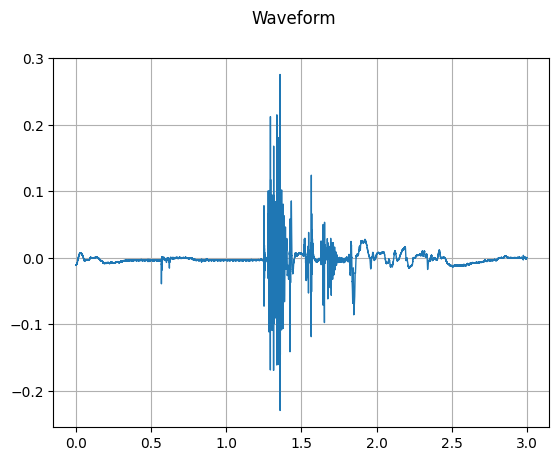

In [29]:
waveform, sample_rate = torchaudio.load(test_audio)
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)

tensor([[-0.0112, -0.0111, -0.0111,  ...,  0.0001,  0.0002,  0.0003]])
Sample Rate: 16000
Shape: (1, 48000)
Dtype: torch.float32
 - Max:      0.275
 - Min:     -0.229
 - Mean:    -0.002
 - Std Dev:  0.014

tensor([[-0.0112, -0.0111, -0.0111,  ...,  0.0001,  0.0002,  0.0003]])



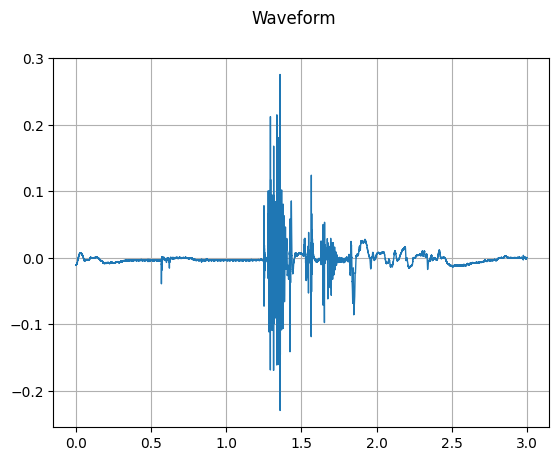

In [41]:
waveform2 = waveform.mean(dim=0, keepdim=True)
print(waveform2)
print_stats(waveform2, sample_rate)
plot_waveform(waveform2, sample_rate)
Audio(waveform2.numpy(), rate=sample_rate)

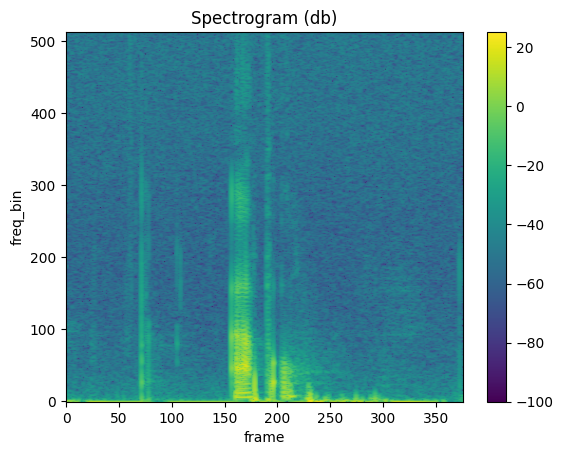

In [31]:
spectrogram = T.Spectrogram(n_fft=1024, hop_length=128)
spec = spectrogram(waveform)
plot_spectrogram(spec[0])

In [32]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return x

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [34]:
print(device)

cpu


In [37]:
model = M5(n_input=1, n_output=4)
model.to(device)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=4, bias=True)
)

In [38]:
num_params(model)

0.0249

In [39]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy().to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [40]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy().to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

In [ ]:
result = torchaudio.load(test_audio)
print(result)
penguins_df["labels"] = penguins_df["species"].map({"Adelie":1, "Chinstrap":0, "Gentoo":2})

(tensor([[-0.0112, -0.0111, -0.0111,  ...,  0.0001,  0.0002,  0.0003]]), 16000)


In [114]:
from torch.utils.data import Dataset
#Creating a dataset class for the audio data
class AudioDataset(Dataset):
    def __init__(self, label_file, file_dir):
        self.df = pd.read_csv(label_file)
        self.labels = df["mapped_labels"]
        self.file_names = df["filenames"]
        self.file_dir = file_dir
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        file_path = os.path.join(self.file_dir, self.file_names[index])
        waveform = torchaudio.load(test_audio)[0]
        label = self.labels[index]
        return waveform, label



In [115]:
dataset = AudioDataset("labels.csv", "Recordings/training/")

In [116]:
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [117]:
model = M5(n_input=1, n_output=4).to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
print(x_batch)
outputs = model(x_batch.to(device)).reshape(32,4)
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor([[[-0.0112, -0.0111, -0.0111,  ...,  0.0001,  0.0002,  0.0003]],

        [[-0.0112, -0.0111, -0.0111,  ...,  0.0001,  0.0002,  0.0003]],

        [[-0.0112, -0.0111, -0.0111,  ...,  0.0001,  0.0002,  0.0003]],

        ...,

        [[-0.0112, -0.0111, -0.0111,  ...,  0.0001,  0.0002,  0.0003]],

        [[-0.0112, -0.0111, -0.0111,  ...,  0.0001,  0.0002,  0.0003]],

        [[-0.0112, -0.0111, -0.0111,  ...,  0.0001,  0.0002,  0.0003]]])


RuntimeError: expected scalar type Long but found Double

In [107]:
from torch.utils.data import random_split
train, test = random_split(dataset, [0.7,0.3])
training_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

In [113]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
# defining Cross-Entropy loss
criterion = torch.nn.CrossEntropyLoss()
 
epochs = 10
Loss = []
acc = []
for epoch in range(epochs):
    for i, (waveform, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(waveform)
        print(i)
        outputs = outputs[:,0,:]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    Loss.append(loss.item())
    correct = 0
    for images, labels in test_loader:
        outputs = model(waveform)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum()
    accuracy = 100 * (correct.item()) / len(test_dataset)
    acc.append(accuracy)
    print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss.item(), accuracy))

0
1
2
3
4
5
6


/tmp/ipykernel_2538/2081469377.py:16: RuntimeWarning: invalid value encountered in cast
  label = self.labels[index].astype(int)


IndexError: Target -9223372036854775808 is out of bounds.